<a href="https://colab.research.google.com/github/HyeonsooKim/AIB/blob/main/AI06_%EA%B9%80%ED%98%84%EC%88%98_Section2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [190]:
# Google Colab으로 수행
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install -U matplotlib=3.0.3
    !pip install delayed
    !pip install eli5
    !pip install xgboost
    !pip install finance-datareader
    !pip install -U finance-datareader
    !pip install pandas_datareader
    !pip install pdpbox
    !pip install shap
    !pip install forex-python
    !pip install html_table_parser
    !pip install html5lib
    !pip install --upgrade html5lib==1.0b8
    !pip install bs4

In [191]:
#주식 데이터셋 불러오기 위한 모듈
import os
import FinanceDataReader as fdr
from pandas_datareader import data
from tqdm import tqdm

#환율정보 가져오기 위한 모듈
from forex_python.converter import CurrencyRates, CurrencyCodes

#웹크롤링을 위한 모듈
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen, Request
from html_table_parser import parser_functions as parser

#시계열 데이트타임
from datetime import datetime

#분석
import pandas as pd
import numpy as np

#시각화
import seaborn as sns
import matplotlib.pyplot as plt

#사이킷런 - 데이터 셋 분리(Time이 들어가는 건 시계열)
from sklearn.model_selection import train_test_split, TimeSeriesSplit

#트리 그릴 때 쓰는 모듈
import graphviz
from sklearn.tree import export_graphviz, DecisionTreeRegressor

#EDA용 데이터 프로파일링
from pandas_profiling import ProfileReport

#범주형 데이터 인코더
from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder

#결측치 채우는 모듈 Imputation
from sklearn.impute import SimpleImputer

#값의 범위에 차이가 있을 때 scaler 사용
from sklearn.preprocessing import StandardScaler

#회귀모델
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge

#데이터 분리, 교차검증
from sklearn.model_selection import train_test_split, cross_val_score

from ipywidgets import interact

#파이프라인
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#앙상블모델 - 랜덤포레스트 분류
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor

#평가지표
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, classification_report, roc_auc_score, r2_score, mean_absolute_error

#벡터머신
from sklearn import svm

#특성고를 때
from sklearn.feature_selection import f_regression, SelectKBest

#하이퍼 파라미터 고를 때 교차검증
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, validation_curve

#랜덤수
from scipy.stats import randint, uniform

#특성 중요도
import eli5
from eli5.sklearn import PermutationImportance

#그래디언트 부스트
import xgboost
from xgboost import XGBClassifier, XGBRegressor

#에이다부스트
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier

#make_pipeline 같은건데 가상의 회귀분석용 데이터 생성
from sklearn.datasets import make_regression

#PDP모듈
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

#comma 없애고 실수형으로 바꿔주는 모듈
from locale import atof, setlocale, LC_NUMERIC

#출력창에 생략없이 출력하는 코드
pd.options.display.max_columns = None
pd.options.display.max_rows = 999

#오류없애주는 코드
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
  display(Audio(url='https://freesound.org/data/previews/219/219244_4082826-lq.mp3', autoplay=True))
## Insert whatever audio file you want above
# allDone()

In [129]:
#구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
#문자열 데이터를 숫자로 바꾸기 위한 함수
def to_int(string):
  try:
    return float(string.replace(',',''))
  except:
    return string

In [131]:
#한글 날짜를 datetime으로 변경
def convert_date(string):
  return pd.Timestamp(string.replace('년 ', '').replace('월 ','')[:-1])

In [132]:
#퍼센티지를 없애고 전날 종가와 차이의 비율을 소수로 나타내는 함수
def del_percentage(string):
  return float(string.replace('%','')) / 100

In [133]:
#날짜에 시간 없애는 함수
def del_clock(string):
  try:
    return string.replace(' 00:00:00','')
  except:
    return string

In [134]:
import re
def parseNumber(value, as_int=False):
    try:
        number = float(re.sub('[^.\-\d]', '', value))
        if as_int:
            return int(number + 0.5)
        else:
            return number
    except ValueError:
        return float('nan')  # or None if you wish

In [135]:
#드라이브 파일 위치
path = '/content/drive/MyDrive/Colab Notebooks/Codestates_Section2(21.08.09~21.09.07)/project'
#종목명, 종목코드, 상장시장 데이터
list_name = 'Stock_List.csv'
stock_list = pd.read_csv(os.path.join(path,list_name))
#제출할 데이터
sample = 'sample_submission.csv'
sample_submission = pd.read_csv(os.path.join(path,sample))

#zfill:총 자릿수를 맞춰주고 앞에 0으로 채워주는 코드
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list.head()

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI


#미국주요 주식지수도 볼 것이기 때문에 환율을 크롤링 하겠습니다

In [136]:
#investing.com에서 원화-달러 환율정보 크롤링할 주소
url = 'https://kr.investing.com/currencies/usd-krw-historical-data'
#s&p500 부족한 데이터 크롤링
snp_url = 'https://finance.yahoo.com/quote/%5EGSPC/history?period1=946684800&period2=1136246400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true'
#항셍 부족한 데이터 크롤링
hang_url = 'https://kr.investing.com/currencies/usd-krw-historical-data'
#헤더파일 파라미터 설정
hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}

#환율 데이터
ra1 = 'change_ratio1.csv'
ra2 = 'change_ratio2.csv'
ratio1 = pd.read_csv(os.path.join(path,ra1), thousands=',')
ratio1 = ratio1.apply(to_int)
ratio2 = pd.read_csv(os.path.join(path,ra2), thousands=',')
ratio2 = ratio2.apply(to_int)
#환율정보 데이터 크롤링, 결합 - 한 번에 불러오기 불가능(홈페이지에서 불가능)
req = Request(url, headers=hdr)
html = urlopen(req).read()
soup=bs(html, "html.parser")

a = soup.find_all('table')[0]
p = parser.make2d(a)
ratio = pd.DataFrame(p[1:], columns=p[0])
ratio = ratio.apply(to_int)
ratio = pd.concat([ratio, ratio2], axis=0)
ratio = pd.concat([ratio, ratio1], axis=0)
#중복값 제거
ratio = ratio.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

ratio['날짜'] = ratio['날짜'].apply(convert_date)

ratio = ratio.rename(columns={'날짜':'Date', '종가':'Close', '오픈':'Open', '고가':'High', '저가':'Low', '변동 %':'Change'})
ratio['Change'] = ratio['Change'].apply(del_percentage)
ratio = ratio.set_index('Date')
ratio = ratio[ratio.index>='20070101']
ratio = ratio.apply(to_int)
ratio = ratio[~ratio.index.duplicated(keep='first')]
ratio.head()

,Close,Open,High,Low,Change
Date,,,,,
2021-09-03,"1,156.81","1,158.09","1,158.52","1,154.50",-0.0011
2021-09-02,"1,158.05","1,156.08","1,162.44","1,155.05",0.0022
2021-09-01,"1,155.47","1,158.95","1,160.64","1,154.54",-0.0028
2021-08-31,"1,158.73","1,166.07","1,167.43","1,155.18",-0.0048
2021-08-30,"1,164.34","1,162.33","1,167.71","1,161.88",0.0027


#핀테크에 관심이 있어 주식 데이터를 이용하여 주식 종가 예측 모델을 시험할 수 있는 Dacon 대회에 참가하였습니다.

##시작가와 종가는 하루 1번 working day를 기준으로 정해지기 때문에 데이터의 수를 늘리기 위해 처음 상장일인 2006년 01월 01일부터의 데이터를 불러왔습니다

In [137]:
#2007년부터 현재까지
start_date = pd.Timestamp('20070101')
# start_date = pd.Timestamp.today() - pd.Timedelta(days=365*10+1)
#어제까지
end_date = pd.Timestamp.today() - pd.Timedelta(days=1)

In [138]:
#코스피지수 (2007.01.01 ~ 2021.08.31) - [2014.09.08]....(x)
kos = 'KS11'
kospi = fdr.DataReader(kos, start = start_date, end = end_date + pd.Timedelta(days=1))
kospi = kospi.rename(columns={'Close':'Kospi_Close', 'Open':'Kospi_Open', 'High':'Kospi_High', 'Low':'Kospi_Low', 'Volume':'Kospi_Volume', 'Change':'Kospi_Change'})
kospi = kospi.apply(to_int)
#코스닥지수 - 2007.01.02 ~
kosd = 'KQ11'
kosdaq = fdr.DataReader(kosd, start = start_date, end = end_date + pd.Timedelta(days=1))
kosdaq = kosdaq.rename(columns={'Close':'Kosdaq_Close', 'Open':'Kosdaq_Open', 'High':'Kosdaq_High', 'Low':'Kosdaq_Low', 'Volume':'Kosdaq_Volume', 'Change':'Kosdaq_Change'})
kosdaq = kosdaq.apply(to_int)

In [139]:
#카카오 (2001.01.01 ~ 2021.08.31) - [2013.12.31, 2014.09.08] ... (x)
# sample_code = '035720'
# stock = fdr.DataReader(sample_code, start = start_date, end = end_date)
#---------------------------------------------------------------------------미국지수-------------------------------------------------------
#나스닥지수 - 2007.01.01 ~
nas = 'IXIC'
nasdaq = fdr.DataReader(nas, start = start_date - pd.Timedelta(days=1), end = end_date)
nasdaq = nasdaq.apply(to_int)

#나스닥 부족한 데이터(2001.01.01~2006.06.14)
nas1 = 'NasDaq.csv'
nas1 = pd.read_csv(os.path.join(path, nas1), thousands=',')
nas1 = nas1.apply(to_int)

#다우존스지수 - 2010.05.14 ~
dow = 'DJI'
dowjones = fdr.DataReader(dow, start = start_date - pd.Timedelta(days=1), end = end_date)
dowjones = dowjones.apply(to_int)
#다우존스 부족한 데이터(2007.01.01~2010.05.13)
dow1 = 'Dowjones.csv'
dow1 = pd.read_csv(os.path.join(path, dow1), thousands=',')
dow1 = dow1.apply(to_int)

#S&P500 - 2007.01.04 ~
snp = 'US500'
snp500 = fdr.DataReader(snp, start = start_date - pd.Timedelta(days=1), end = end_date)
snp500 = snp500.rename(columns={'Close':'SnP500_Close', 'Open':'SnP500_Open', 'High':'SnP500_High', 'Low':'SnP500_Low', 'Change':'SnP500_Change'})
snp500 = snp500.apply(to_int)
#---------------------------------------------------------------------------일본지수-------------------------------------------------------
#닛케이 2011.07.01~
nk = 'JP225'
nitkei = fdr.DataReader(nk, start = start_date, end = end_date)
nitkei = nitkei.apply(to_int)
#닛케이 부족한 데이터(2007.01.01~2011.06.30)
nit1 = 'nitkei.csv'
nit1 = pd.read_csv(os.path.join(path, nit1), thousands=',')
nit1 = nit1.apply(to_int)
#---------------------------------------------------------------------------중국지수-------------------------------------------------------
cs = 'CSI300'
sci300 = fdr.DataReader(cs, start = start_date, end = end_date)
sci300 = sci300.apply(to_int)
#---------------------------------------------------------------------------홍콩지수-------------------------------------------------------
#항셍 최신데이터 크롤링
req = Request(url, headers=hdr)
html = urlopen(req).read()
soup=bs(html, "html.parser")

aaa = soup.find_all('table')[0]
ppp = parser.make2d(aaa)
hang_seng = pd.DataFrame(ppp[1:], columns=ppp[0])
#항셍 부족한 데이터(2007.01.01~2021.09.02)
hang1 = 'hangseng.csv'
hang1 = pd.read_csv(os.path.join(path, hang1), thousands=',')
hang1 = hang1.apply(to_int)

In [140]:
#나스닥 데이터 합치기
nasdaq = nasdaq.drop(columns='Volume')

nas1['날짜'] = nas1['날짜'].apply(convert_date)
nas1 = nas1.rename(columns={'날짜':'Date', '종가':'Close', '오픈':'Open', '고가':'High', '저가':'Low', '거래량':'Volume', '변동 %':'Change'})
nas1 = nas1.drop(columns='Volume')
nas1 = nas1.set_index('Date').sort_values(by='Date')
nas1['Change'] = nas1['Change'].apply(del_percentage)

nasdaq = pd.concat([nas1, nasdaq])
nasdaq = nasdaq.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
nasdaq = nasdaq[nasdaq.index>=start_date]
nasdaq = nasdaq.rename(columns={'Close':'Nasdaq_Close', 'Open':'Nasdaq_Open', 'High':'Nasdaq_High', 'Low':'Nasdaq_Low', 'Change':'Nasdaq_Change'})
nasdaq = nasdaq.apply(to_int)
nasdaq.head()

,Nasdaq_Close,Nasdaq_Open,Nasdaq_High,Nasdaq_Low,Nasdaq_Change
Date,,,,,
2007-01-03,2423.2,2429.7,2454.6,2394.7,0.0033
2007-01-04,2453.4,2423.8,2460.5,2413.8,0.0125
2007-01-05,2434.3,2445.1,2445.1,2420.6,-0.0078
2007-01-08,2438.2,2435.3,2445.6,2421.1,0.0016
2007-01-09,2443.8,2443.3,2449.9,2423.6,0.0023


In [141]:
#다우존스 데이터 합치기
dowjones = dowjones.drop(columns='Volume')
dowjones = dowjones.reset_index()
dowjones['Date'] = dowjones['Date'].apply(del_clock)
dowjones = dowjones.set_index('Date')
dowjones = dowjones.apply(to_int)

dow1['날짜'] = dow1['날짜'].apply(convert_date)
dow1 = dow1.rename(columns={'날짜':'Date', '종가':'Close', '오픈':'Open', '고가':'High', '저가':'Low', '거래량':'Volume', '변동 %':'Change'})
dow1 = dow1.drop(columns='Volume')
# dow1['Date'] = dow1['Date'].apply(del_clock)
# dow1['Date'] = pd.Timestamp(dow1['Date'])
dow1 = dow1.set_index('Date').sort_values(by='Date')
dow1 = dow1.apply(to_int)
dow1['Change'] = dow1['Change'].apply(del_percentage)

dowjones = pd.concat([dow1, dowjones])
dowjones = dowjones.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
dowjones = dowjones[dowjones.index>=start_date]
dowjones = dowjones.rename(columns={'Close':'DowJones_Close', 'Open':'DowJones_Open', 'High':'DowJones_High', 'Low':'DowJones_Low', 'Change':'DowJones_Change'})
dowjones = dowjones.apply(to_int)
dowjones.head()

,DowJones_Close,DowJones_Open,DowJones_High,DowJones_Low,DowJones_Change
Date,,,,,
2007-01-04,12480.69,12467.32,12510.26,12405.47,0.0005
2007-01-05,12398.01,12480.05,12504.40,12326.79,-0.0066
2007-01-08,12423.49,12393.93,12445.37,12337.53,0.0021
2007-01-09,12416.60,12424.77,12516.66,12337.85,-0.0006
2007-01-10,12442.16,12417.00,12487.18,12313.01,0.0021


In [142]:
#닛케이 데이터 합치기
nitkei = nitkei.drop(columns='Volume')

nit1['날짜'] = nit1['날짜'].apply(convert_date)
nit1 = nit1.rename(columns={'날짜':'Date', '종가':'Close', '오픈':'Open', '고가':'High', '저가':'Low', '거래량':'Volume', '변동 %':'Change'})
nit1 = nit1.drop(columns='Volume')
nit1 = nit1.set_index('Date').sort_values(by='Date')
nit1['Change'] = nit1['Change'].apply(del_percentage)

nitkei = pd.concat([nit1, nitkei])
nitkei = nitkei.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
nitkei = nitkei.rename(columns={'Close':'Nitkei_Close', 'Open':'Nitkei_Open', 'High':'Nitkei_High', 'Low':'Nitkei_Low', 'Change':'Nitkei_Change'})
nitkei = nitkei.apply(to_int)
nitkei

,Nitkei_Close,Nitkei_Open,Nitkei_High,Nitkei_Low,Nitkei_Change
Date,,,,,
2006-01-04,16361.54,16294.65,16361.54,16250.76,0.0155
2006-01-05,16425.37,16441.27,16474.52,16368.51,0.0039
2006-01-06,16428.21,16408.31,16479.55,16320.43,0.0002
2006-01-10,16124.35,16487.05,16487.05,16124.35,-0.0185
2006-01-11,16363.59,16164.92,16363.59,16005.24,0.0148
...,...,...,...,...,...
2021-08-27,27641.14,27581.24,27670.66,27481.23,-0.0036
2021-08-30,27789.29,27867.60,27921.55,27656.63,0.0054
2021-08-31,28089.54,27690.77,28158.95,27602.21,0.0108


In [143]:
#항셍 데이터 합치기
# hang_seng['날짜'] = hang_seng['날짜'].apply(convert_date)
# hang_seng = hang_seng.rename(columns={'날짜':'Date', '종가':'Close', '오픈':'Open', '고가':'High', '저가':'Low', '거래량':'Volume', '변동 %':'Change'})

# hang_seng = hang_seng.set_index('Date').sort_values(by='Date')
# hang_seng['Change'] = hang_seng['Change'].apply(del_percentage)

hang1['날짜'] = hang1['날짜'].apply(convert_date)
hang1 = hang1.rename(columns={'날짜':'Date', '종가':'Close', '오픈':'Open', '고가':'High', '저가':'Low', '거래량':'Volume',  '변동 %':'Change'})
hang1 = hang1.drop(columns='Volume')
hang1 = hang1.set_index('Date').sort_values(by='Date')
hang1['Change'] = hang1['Change'].apply(del_percentage)

# hang_seng = pd.concat([hang1, hang_seng])
hang_seng = hang1
# hang_seng = hang_seng.drop(columns='Volume')
# hang_seng = hang_seng.drop_duplicates(subset=None, keep='last', inplace=False, ignore_index=False)
hang_seng = hang_seng.rename(columns={'Close':'Hang_Close', 'Open':'Hang_Open', 'High':'Hang_High', 'Low':'Hang_Low', 'Change':'Hang_Change'})
hang_seng = hang_seng.apply(to_int)
hang_seng = hang_seng[hang_seng.index>'20070101']
hang_seng

,Hang_Close,Hang_Open,Hang_High,Hang_Low,Hang_Change
Date,,,,,
2007-01-02,20310.18,20004.84,20323.59,19990.28,0.0173
2007-01-03,20413.39,20353.42,20554.58,20249.61,0.0051
2007-01-04,20025.58,20415.67,20463.18,19948.02,-0.0190
2007-01-05,20211.28,19890.15,20213.64,19757.24,0.0093
2007-01-08,20029.66,19915.00,20085.58,19844.31,-0.0090
...,...,...,...,...,...
2021-08-27,25407.89,25337.55,25641.33,25304.62,-0.0003
2021-08-30,25539.54,25406.49,25583.59,25219.80,0.0052
2021-08-31,25878.99,25524.23,25878.99,25110.72,0.0133


###모든 데이터 합칠 때 쓰는 코드 - 쓰지않음

In [144]:
# nas_list = []
# for i in nasdaq.columns:
#   nas_list.append("Nasdaq_"+i)
# dow_list = []
# for i in dowjones.columns:
#   dow_list.append("DowJones_"+i)
# snp_list = []
# for i in snp500.columns:
#   snp_list.append("S&P500_"+i)
# kos_list = []
# for i in kospi.columns:
#   kos_list.append("Kospi_"+i)
# kods_list = []
# for i in kosdaq.columns:
#   kods_list.append("Kosdaq_"+i)
# exch_list = ['Close', 'Open', 'High', 'Low', 'Change']
# exc_list = []
# dow1_list = []
# for i in exch_list:
#   exc_list.append("ExRate_"+i)
#   dow1_list.append("DowJones_"+i)

In [145]:
# a = [dow1_list, dow_list]
# b = [dow1, dowjones]
# c = pd.DataFrame([])
# for i, j in zip(a, b):
#   h = dict(zip(j, i))
#   j = j.rename(columns=h)
#   c = pd.concat([c,j])

In [146]:
# #각 데이터의 특성에 이름 붙이기
# a = [nas_list, dow_list, snp_list, kos_list, kods_list, exc_list, dow1_list]
# b = [nasdaq, dowjones, snp500, kospi, kosdaq, ratio, dow1]
# total = pd.DataFrame([])

In [147]:
# for i, j in zip(a, b):
#   h = dict(zip(j, i))
#   # print(h)
#   j = j.rename(columns=h)
#   #하나의 데이터로 합치기
#   total = pd.concat([total, j], axis=1)
#   if a == dow1_list:
#     total = pd.concat([total, j], axis=1, join='inner')

# # total.fillna(method='ffill')
# total

In [148]:
# #카카오에는 2013년 12월 31일 거래 정보가 없음 - 12월 30일 장 마감
# kospi = kospi[kospi.index != '2013-12-31 00:00:00']

In [149]:
# #코스피에 2014년 9월 8일 거래정보가 없음 - 추석
# kosdaq = kosdaq[kosdaq.index != '20140908']
# #카카오에는 2013년 12월 31일 거래 정보가 없음 - 12월 30일 장 마감
# kosdaq = kosdaq[kosdaq.index != '20131231']

##거래량(Volume)과 종가(Close)의 관계에 대해 단순선형 회귀그래프를 확인해보겠습니다

In [211]:
kospi

,Kospi_Close,Kospi_Open,Kospi_High,Kospi_Low,Kospi_Volume,Kospi_Change
Date,,,,,,
2007-01-02,1435.26,1438.89,1439.71,1430.06,147740000.0,0.0006
2007-01-03,1409.35,1436.42,1437.79,1409.31,203210000.0,-0.0181
2007-01-04,1397.29,1410.55,1411.12,1388.50,241170000.0,-0.0086
2007-01-05,1385.76,1398.60,1400.59,1372.36,277290000.0,-0.0083
2007-01-08,1370.81,1376.76,1384.65,1366.48,177590000.0,-0.0108
...,...,...,...,...,...,...
2021-08-30,3144.19,3160.87,3164.87,3132.77,602860000.0,0.0033
2021-08-31,3199.27,3144.49,3199.89,3130.30,661220000.0,0.0175
2021-09-01,3207.02,3195.67,3215.13,3185.80,746710000.0,0.0024


###코스피 부분

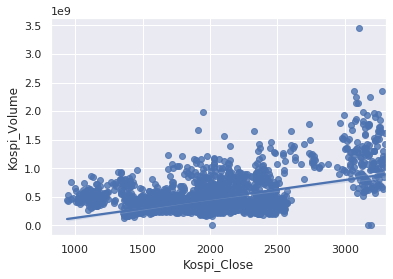

In [150]:
#코스피 기울기가 양수인 선형회귀를 확인할 수 있습니다. - (O)
sns.regplot(x='Kospi_Close', y='Kospi_Volume', data=kospi)

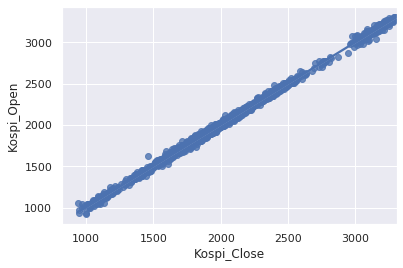

In [151]:
# 코스피 시작가와 종가는 선형관계에 있다고 할 수 있다 - (O)
sns.regplot(x='Kospi_Close', y='Kospi_Open', data=kospi)

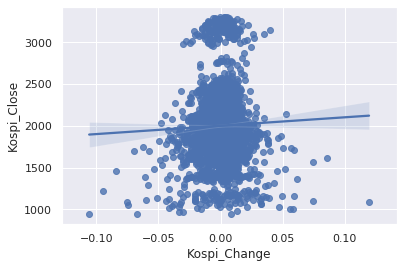

In [152]:
# 코스피 변동률과 종가는 선형관계에 있다고 할 수 있다 - 선형관계보다는 수직선이 회귀선으로 더 적당할 듯함
sns.regplot(x='Kospi_Change', y='Kospi_Close', data=kospi)

###코스닥 부분

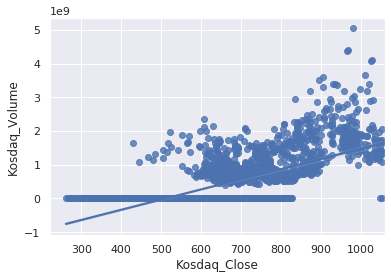

In [153]:
#수평선의 경우 데이터가 부족하여 0으로 대체된 부분
#코스닥 기울기가 양수인 선형회귀를 확인할 수 있습니다. - (O)
sns.regplot(x='Kosdaq_Close', y='Kosdaq_Volume', data=kosdaq)

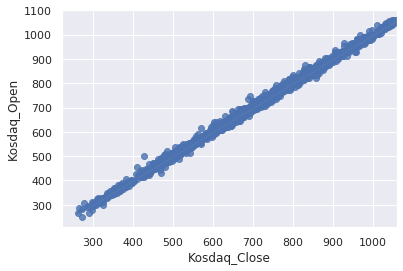

In [154]:
# 코스닥 시작가와 종가는 선형관계에 있다고 할 수 있다 - (O)
sns.regplot(x='Kosdaq_Close', y='Kosdaq_Open', data=kosdaq)

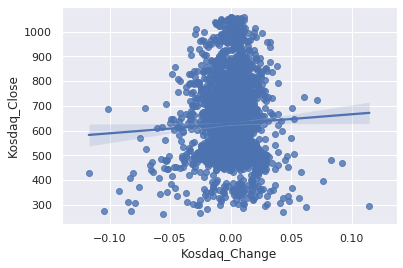

In [155]:
# 코스닥 변동률과 종가는 선형관계에 있다고 할 수 있다 - 선형관계보다는 수직선이 회귀선으로 더 적당할 듯함
sns.regplot(x='Kosdaq_Change', y='Kosdaq_Close', data=kosdaq)

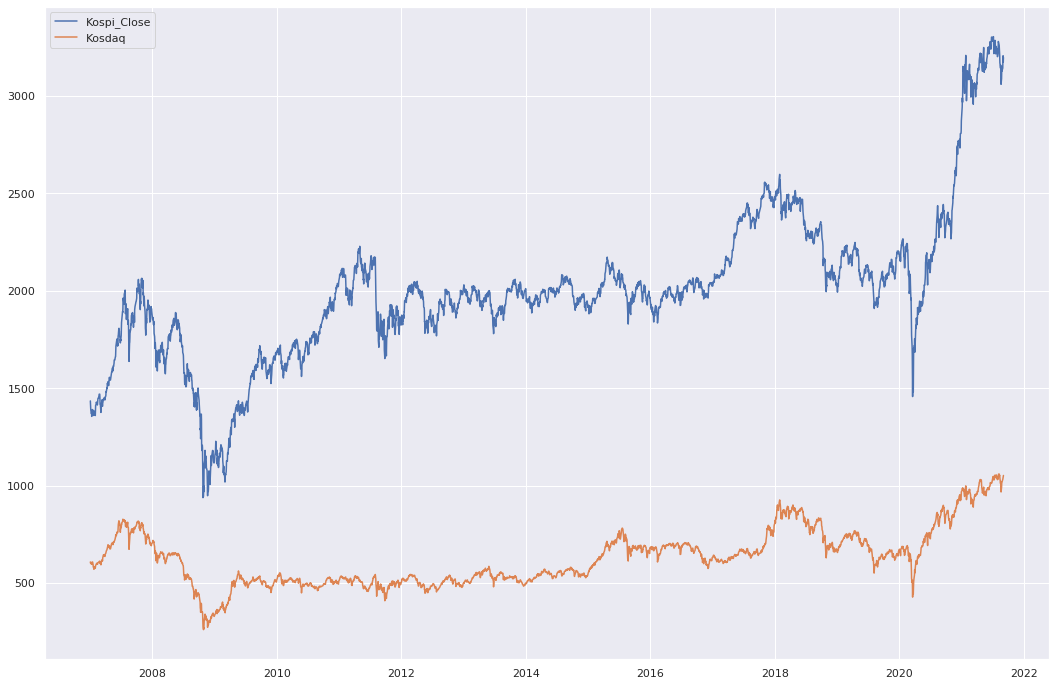

In [156]:
%matplotlib inline
sns.set(rc = {'figure.figsize':(18,12)})
plt.plot(kospi['Kospi_Close'], label = 'Kospi_Close')
plt.plot(kosdaq['Kosdaq_Close'], label = 'Kosdaq')
plt.legend()

(5, 0)

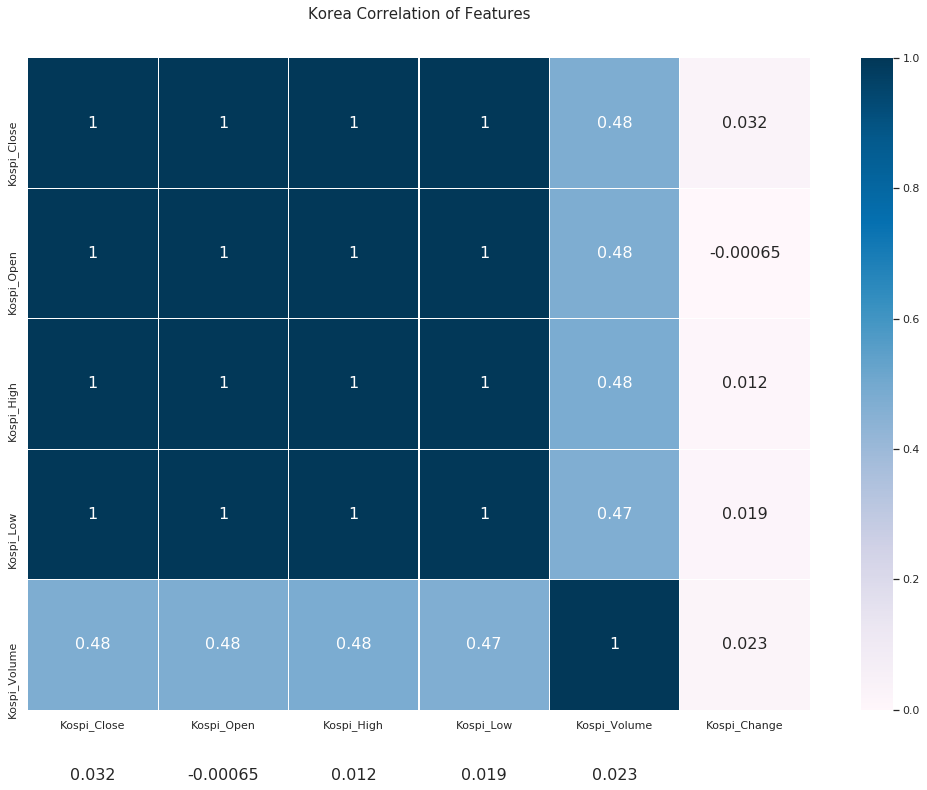

In [210]:
%matplotlib inline

plt.figure(figsize=(18, 12)) 
plt.title("Korea Correlation of Features", y = 1.05, size = 15)
sns.heatmap(kospi.corr(),linewidths = 0.1, vmax = 1.0, square = True, cmap = plt.cm.PuBu, linecolor = "white", annot = True, annot_kws = {"size" : 16}).set_ylim(5,0)

###미국 주식의 그래프를 보겠습니다

In [157]:
# dpi(dots per inch) 수치를 조정해 이미지 화질을 조정 할 수 있습니다
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

In [158]:
#미 주식 주요 지표 3개를 묶은 데이터프레임
america = pd.concat([dowjones['DowJones_Close'], nasdaq['Nasdaq_Close'], snp500['SnP500_Close']], axis=1)
america = america.fillna(method='bfill')
america = america.apply(to_int)

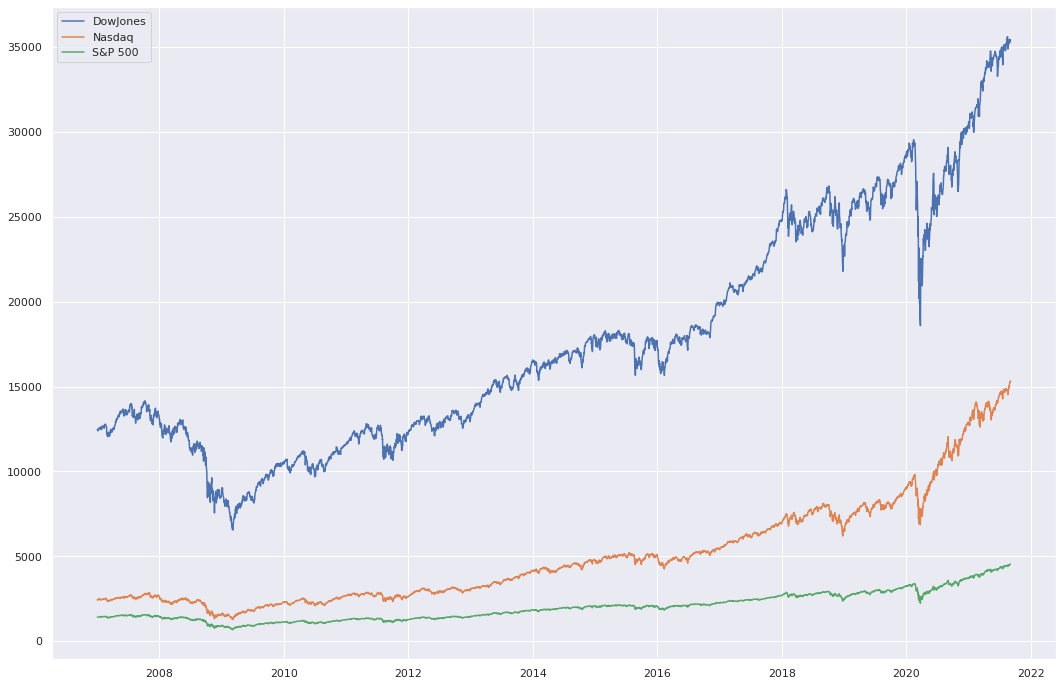

In [159]:
%matplotlib inline
sns.set(rc = {'figure.figsize':(18,12)})
plt.plot(america['DowJones_Close'], label = 'DowJones')
plt.plot(america['Nasdaq_Close'], label = 'Nasdaq')
plt.plot(america['SnP500_Close'], label = 'S&P 500')
plt.legend()

In [160]:
america.corr()

,DowJones_Close,Nasdaq_Close,SnP500_Close
DowJones_Close,1.000000,0.971287,0.994019
Nasdaq_Close,0.971287,1.000000,0.985744
SnP500_Close,0.994019,0.985744,1.000000


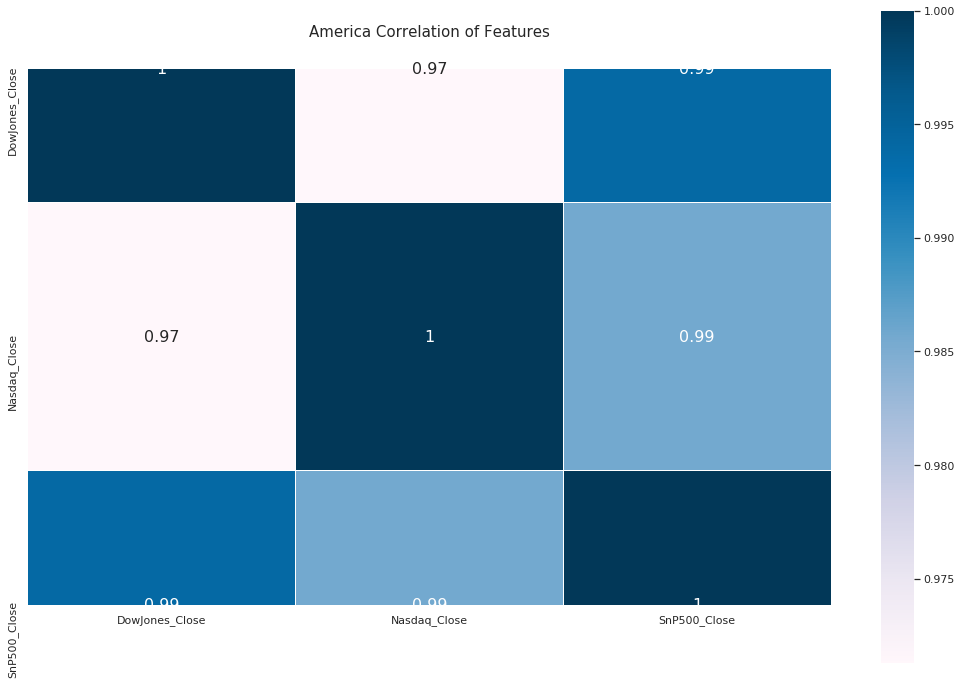

In [198]:
%matplotlib inline
plt.figure(figsize=(18, 12)) 
plt.title("America Correlation of Features", y = 1.05, size = 15)
sns.heatmap(america.corr(),linewidths = 0.1, vmax = 1.0, square = True, cmap = plt.cm.PuBu, linecolor = "white", annot = True, annot_kws = {"size" : 16})

###환율을 추가해서 한 번 보겠습니다

In [162]:
n = []
nn = []
nnn = pd.DataFrame([], columns=['Date', 'XR_Close'])
for i in ratio.index:
  if i in america.index:
    n.append(i)
    a = str(ratio['Close'][i]).replace(',','')
    nn.append(a)

nnn['Date'] = n
nnn['XR_Close'] = nn
# nnn['XR_Close'][0] = '1,156.10'
nnn = nnn.set_index('Date')

In [163]:
america['XR_Close'] = nnn

In [164]:
america.corr()

,DowJones_Close,Nasdaq_Close,SnP500_Close
DowJones_Close,1.000000,0.971287,0.994019
Nasdaq_Close,0.971287,1.000000,0.985744
SnP500_Close,0.994019,0.985744,1.000000


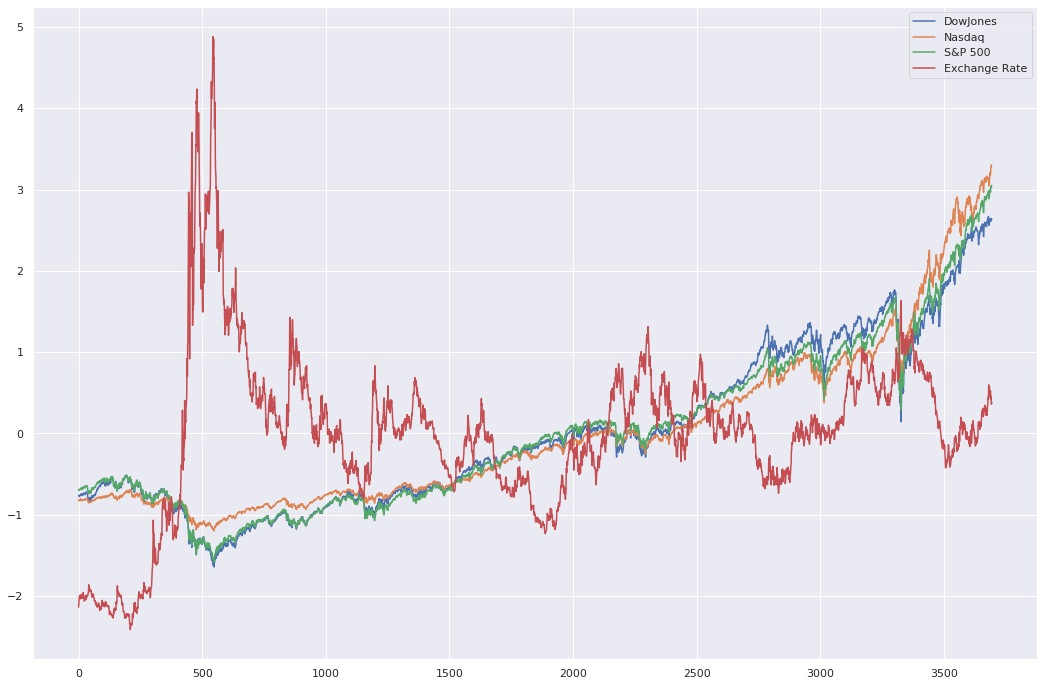

In [165]:
%matplotlib inline
scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(america), columns=['DowJones_Close', 'Nasdaq_Close', 'SnP500_Close', 'XR_Close'])

sns.set(rc = {'figure.figsize':(18,12)})
plt.plot(scaled['DowJones_Close'], label = 'DowJones')
plt.plot(scaled['Nasdaq_Close'], label = 'Nasdaq')
plt.plot(scaled['SnP500_Close'], label = 'S&P 500')
plt.plot(scaled['XR_Close'], label = 'Exchange Rate')
plt.legend()

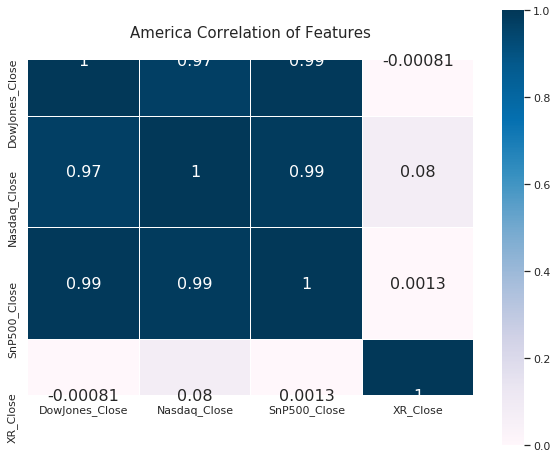

In [193]:
%matplotlib inline
plt.figure(figsize=(18, 12)) 
plt.title("America Correlation of Features", y = 1.05, size = 15)
sns.heatmap(scaled.corr(),linewidths = 0.1, vmax = 1.0, square = True, cmap = plt.cm.PuBu, linecolor = "white", annot = True, annot_kws = {"size" : 16})

In [167]:
c = []
cc = []
ccc = pd.DataFrame([], columns=['Date', 'XR_Close'])
for i in ratio.index:
  if i in kospi.index:
    c.append(i)
    a = str(ratio['Close'][i]).replace(',','')
    cc.append(a)

ccc['Date'] = n
ccc['XR_Close'] = nn
ccc = ccc.set_index('Date')

###미국주식과 한국주식의 차트를 한 그래프에 그려보겠습니다

In [168]:
Komerica = pd.concat([america, kospi['Kospi_Close'], kosdaq['Kosdaq_Close']], axis=1)
# Komerica['Kospi_Close'] = kospi['Kospi_Close']
# Komerica['Kosdaq_Close'] = kosdaq['Kosdaq_Close']
Komerica = Komerica.bfill().ffill()

In [169]:
Komerica

,DowJones_Close,Nasdaq_Close,SnP500_Close,XR_Close,Kospi_Close,Kosdaq_Close
Date,,,,,,
2007-01-02,12480.69,2423.2,1416.60,926.15,1435.26,608.72
2007-01-03,12480.69,2423.2,1416.60,926.15,1409.35,602.69
2007-01-04,12480.69,2453.4,1418.34,931.35,1397.29,603.94
2007-01-05,12398.01,2434.3,1409.71,934.45,1385.76,602.35
2007-01-08,12423.49,2438.2,1412.84,938.1,1370.81,597.83
...,...,...,...,...,...,...
2021-08-30,35399.90,15265.9,4528.79,1164.34,3144.19,1031.84
2021-08-31,35359.08,15259.2,4522.68,1158.73,3199.27,1038.33
2021-09-01,35313.22,15309.4,4524.09,1155.47,3207.02,1045.98


(6, 0)

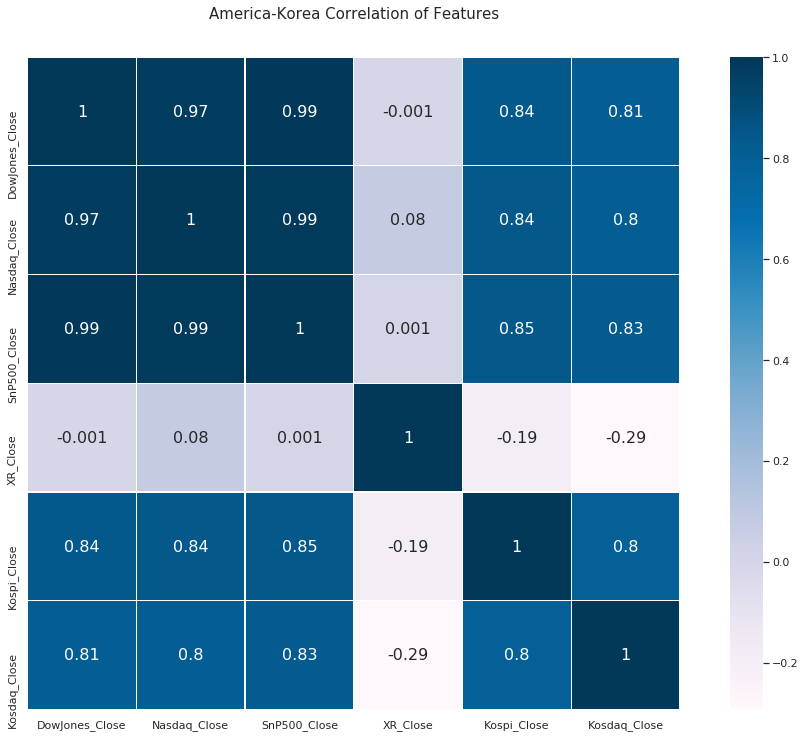

In [206]:
%matplotlib inline

plt.figure(figsize=(18, 12)) 
plt.title("America-Korea Correlation of Features", y = 1.05, size = 15)
scaled1 = pd.DataFrame(scaler.fit_transform(Komerica), columns=Komerica.columns)
sns.heatmap(scaled1.corr(),linewidths = 0.1, vmax = 1.0, square = True, cmap = plt.cm.PuBu, linecolor = "white", annot = True, annot_kws = {"size" : 16}).set_ylim(6,0)

* 환율은 상관계수도 낮고 큰 영향이 없다
* 미국 주요지수와 코스닥과 코스피는 상관관계가 높은 편이다

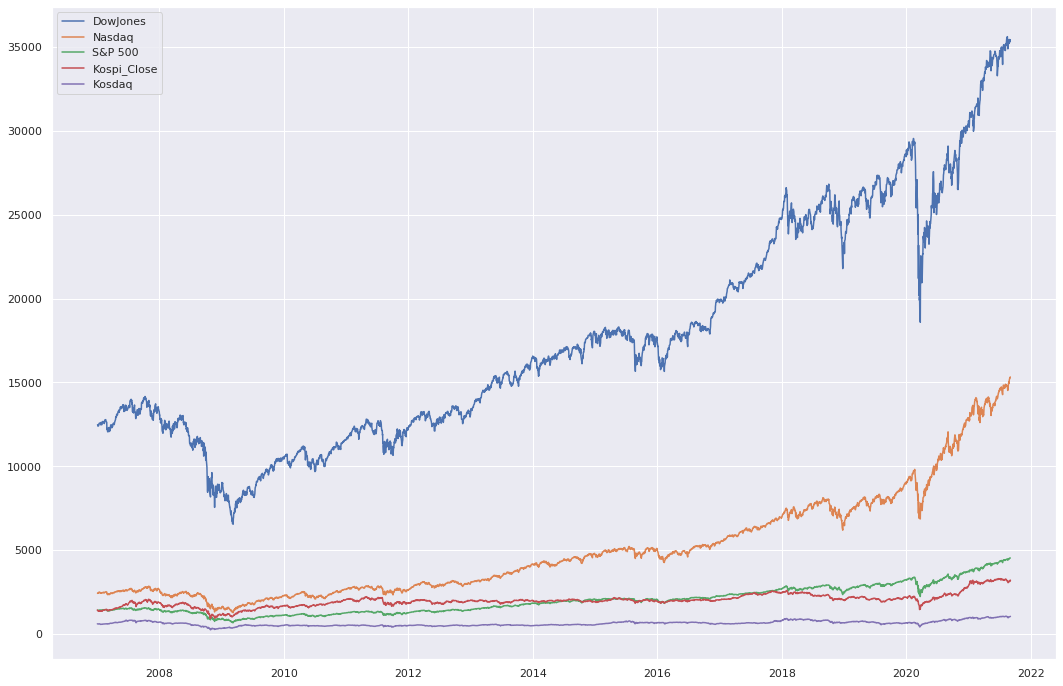

In [171]:
%matplotlib inline
sns.set(rc = {'figure.figsize':(18,12)})
plt.plot(america['DowJones_Close'], label = 'DowJones')
plt.plot(america['Nasdaq_Close'], label = 'Nasdaq')
plt.plot(america['SnP500_Close'], label = 'S&P 500')
plt.plot(kospi['Kospi_Close'], label = 'Kospi_Close')
plt.plot(kosdaq['Kosdaq_Close'], label = 'Kosdaq')
plt.legend()

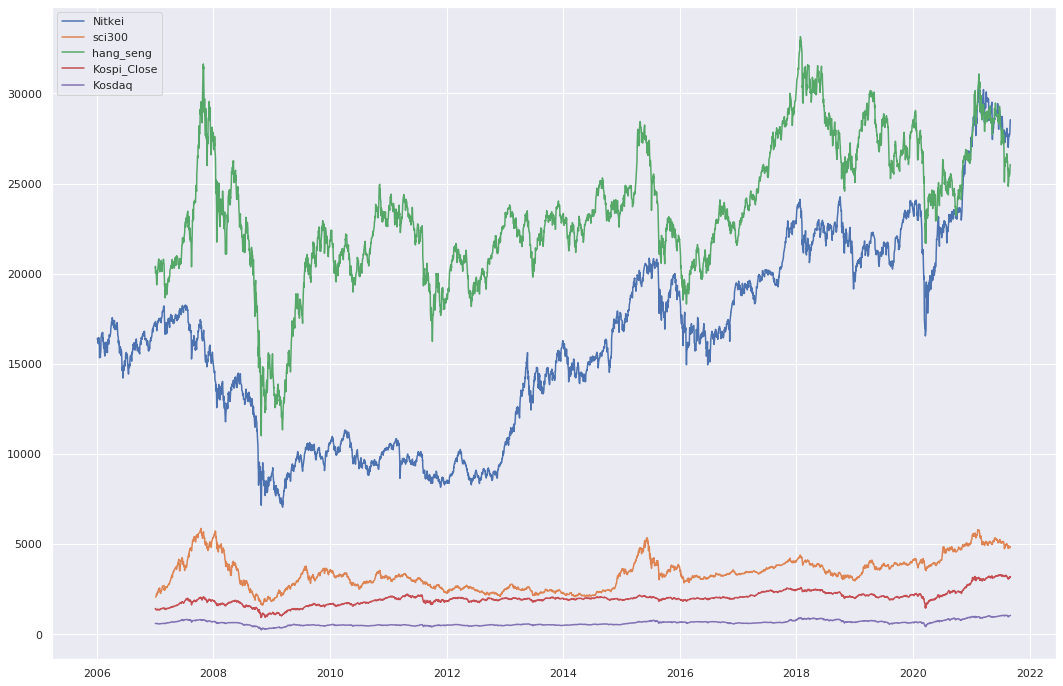

In [172]:
%matplotlib inline
sns.set(rc = {'figure.figsize':(18,12)})
plt.plot(nitkei['Nitkei_Close'], label = 'Nitkei')
plt.plot(sci300['Close'], label = 'sci300')
plt.plot(hang_seng['Hang_Close'], label = 'hang_seng')
plt.plot(kospi['Kospi_Close'], label = 'Kospi_Close')
plt.plot(kosdaq['Kosdaq_Close'], label = 'Kosdaq')
plt.legend()

In [173]:
Kosia = pd.concat([hang_seng['Hang_Close'],sci300['Close'], nitkei['Nitkei_Close'], kospi['Kospi_Close'], kosdaq['Kosdaq_Close']], axis=1)
# Kosia['Kospi_Close'] = kospi['Kospi_Close']
# Kosia['Kosdaq_Close'] = kosdaq['Kosdaq_Close']
Kosia = Kosia.bfill().ffill()

(5, 0)

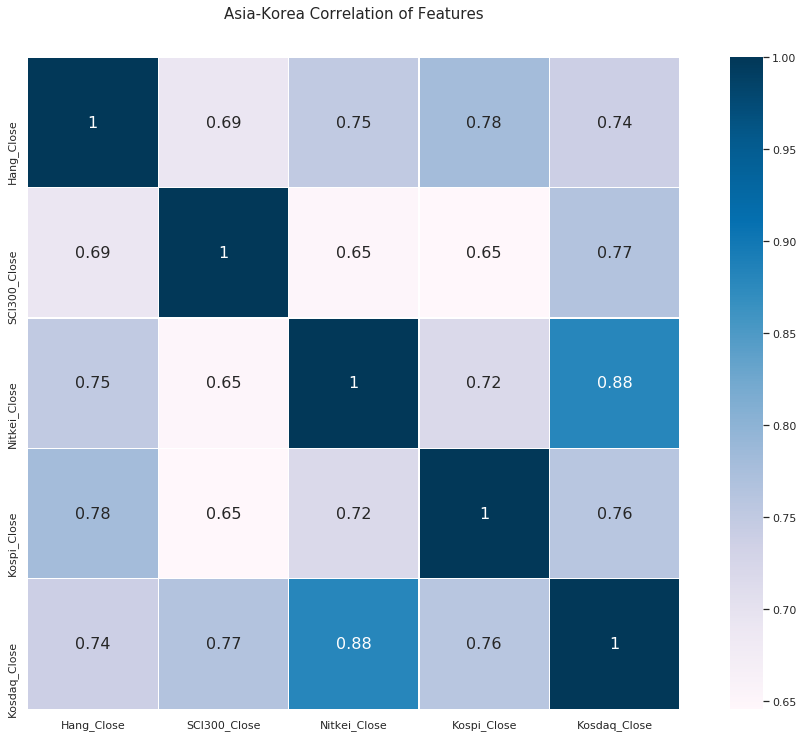

In [208]:
%matplotlib inline

plt.figure(figsize=(18, 12)) 
plt.title("Asia-Korea Correlation of Features", y = 1.05, size = 15)
Kosia = Kosia.rename(columns={'Close':'SCI300_Close'})
scaled2 = pd.DataFrame(scaler.fit_transform(Kosia), columns=Kosia.columns)
sns.heatmap(scaled2.corr(),linewidths = 0.1, vmax = 1.0, square = True, cmap = plt.cm.PuBu, linecolor = "white", annot = True, annot_kws = {"size" : 16}).set_ylim(5,0)

코스닥은 닛케이

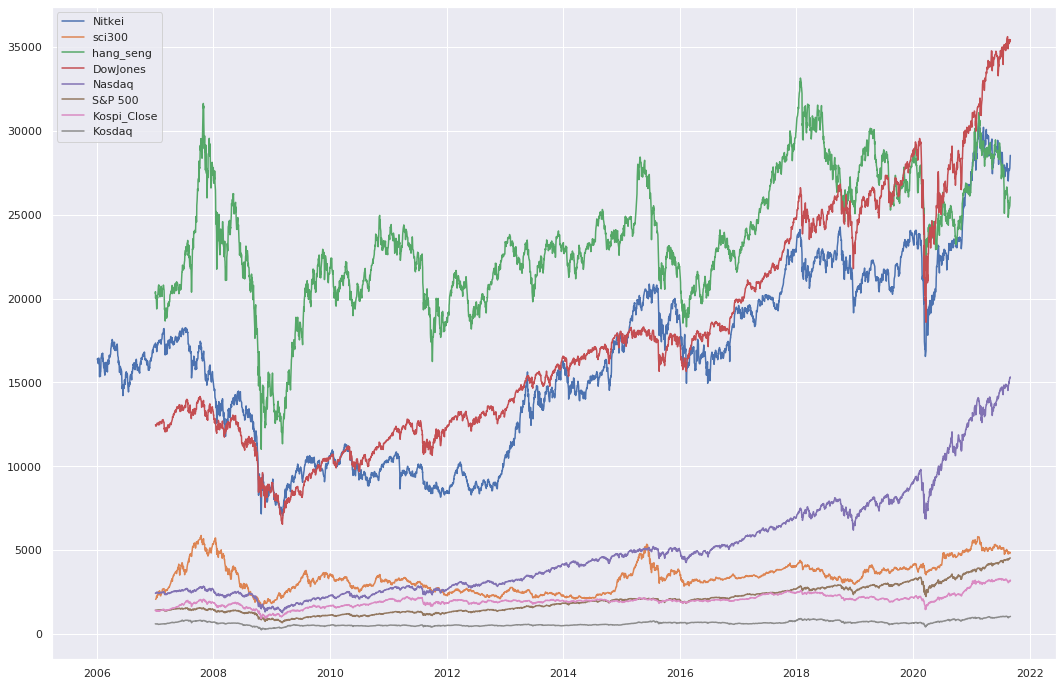

In [175]:
%matplotlib inline
sns.set(rc = {'figure.figsize':(18,12)})
plt.plot(nitkei['Nitkei_Close'], label = 'Nitkei')
plt.plot(sci300['Close'], label = 'sci300')
plt.plot(hang_seng['Hang_Close'], label = 'hang_seng')
plt.plot(america['DowJones_Close'], label = 'DowJones')
plt.plot(america['Nasdaq_Close'], label = 'Nasdaq')
plt.plot(america['SnP500_Close'], label = 'S&P 500')
plt.plot(kospi['Kospi_Close'], label = 'Kospi_Close')
plt.plot(kosdaq['Kosdaq_Close'], label = 'Kosdaq')
plt.legend()

In [176]:
Kosimerica = Komerica.merge(Kosia)
# Kosimerica['Kospi_Close'] = kospi['Kospi_Close']
# Kosimerica['Kosdaq_Close'] = kosdaq['Kosdaq_Close']
Kosimerica = Kosimerica.bfill().ffill()
scaled3 = pd.DataFrame(scaler.fit_transform(Kosimerica), columns=Kosimerica.columns)

In [177]:
kospi.shape, Kosimerica.shape, Komerica.shape

((3631, 6), (4522, 9), (3803, 6))

(9, 0)

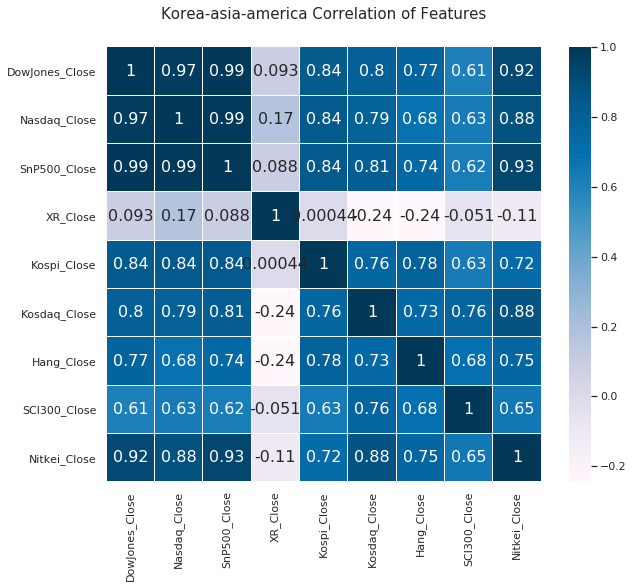

In [209]:
%matplotlib inline

plt.figure(figsize=(10, 8)) 
plt.title("Korea-asia-america Correlation of Features", y = 1.05, size = 15)
sns.heatmap(scaled3.corr(),linewidths = 0.1, vmax = 1.0, square = True, cmap = plt.cm.PuBu, linecolor = "white", annot = True, annot_kws = {"size" : 16}).set_ylim(9,0)

##기본모델 - 대회측 제공

In [214]:
#시작날짜와 종료날짜
start_date = '20210104'
end_date = '20210827'

#월요일 0, 화요일 1, 수요일 2, 목요일 3, 금요일 4로 표시 - 시작하는 날의 데이터
start_weekday = pd.to_datetime(start_date).weekday()
#시작일로부터 몇주째인지 나타냄
max_weeknum = pd.to_datetime(end_date).strftime('%V')
#영업일('B')를 기준으로 시작일부터 마지막날짜까지의 날짜
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq='B'), columns = ['Date'])

print(f'WEEKDAY of "start_date" : {start_weekday}')
print(f'NUM of WEEKS to "end_date" : {max_weeknum}')
print(f'HOW MANY "Business_days" : {Business_days.shape}', )
display(Business_days.head())

WEEKDAY of "start_date" : 0
NUM of WEEKS to "end_date" : 34
HOW MANY "Business_days" : (170, 1)


,Date
0,2021-01-04
1,2021-01-05
2,2021-01-06
3,2021-01-07
4,2021-01-08


In [215]:
#삼성전자
sample_code = stock_list.loc[0,'종목코드']
#삼성전자 데이터 불러서 인덱스 재정렬
sample = fdr.DataReader(sample_code, start = start_date, end = end_date)[['Close']].reset_index()
#날짜와 삼전 주가를 합친 데이터
sample = pd.merge(Business_days, sample, how = 'outer')
#weekday 특성은 월화수목금 -> 01234로 바꿈
sample['weekday'] = sample.Date.apply(lambda x : x.weekday())
#weeknum은 몇 주 째인지 확인
sample['weeknum'] = sample.Date.apply(lambda x : x.strftime('%V'))
#시스템에서 계산하지 못하는 공휴일과 같은 장 휴무일(결측치)에 전날 종가를 넣음
sample.Close = sample.Close.ffill()
#통계정보 확인하기 위해 삼전의 주마다, 요일마다의 데이터 확인
sample = pd.pivot_table(data = sample, values = 'Close', columns = 'weekday', index = 'weeknum')
sample.head()

weekday,0,1,2,3,4
weeknum,,,,,
01,83000.0,83900.0,82200.0,82900.0,88800.0
02,91000.0,90600.0,89700.0,89700.0,88000.0
03,85000.0,87000.0,87200.0,88100.0,86800.0
04,89400.0,86700.0,85600.0,83700.0,82000.0
05,83000.0,84400.0,84600.0,82500.0,83500.0


In [216]:
#선형회귀모델
model = LinearRegression()

In [217]:
#마지막 2주를 제외한 0-31주차의 데이터
x = sample.iloc[0:-2].to_numpy()
x.shape

(32, 5)

In [218]:
#1-32주차의 데이터
y = sample.iloc[1:-1].to_numpy()
y_0 = y[:,0]
y_1 = y[:,1]
y_2 = y[:,2]
y_3 = y[:,3]
y_4 = y[:,4]

y_values = [y_0, y_1, y_2, y_3, y_4]

In [219]:
# 7월 마지막 주 데이터 (31주차 데이터)
x_public = sample.iloc[-2].to_numpy()

In [220]:
predictions = []
for y_value in y_values :
    model.fit(x,y_value)
    #x_public에 차원 추가
    prediction = model.predict(np.expand_dims(x_public,0))
    predictions.append(prediction[0])
predictions

[73058.5912452854,
 72663.61542062866,
 72716.19838336245,
 73315.98052095695,
 73515.70992550459]

##시계열 데이터이므로 데이터를 분리할 때 시계열에 맞게 분리하도록 하겠습니다

In [186]:
Kosimerica.isnull().sum()

DowJones_Close    0
Nasdaq_Close      0
SnP500_Close      0
XR_Close          0
Kospi_Close       0
Kosdaq_Close      0
Hang_Close        0
SCI300_Close      0
Nitkei_Close      0
dtype: int64

In [239]:
target = 'Kospi_Close'
feature = Komerica.drop(columns=['Kospi_Close', 'XR_Close']).columns

#train은 2017년까지
X = Komerica[Komerica.index<'20170101'][feature]
y = Komerica[Komerica.index<'20170101'][target]
#test는 2020년 부터
test = Komerica[Komerica.index>='20200101']
#val은 2017년부터 2019년까지
# val = Komerica[Komerica.index>='20170101'].drop(test.index)
X_test = test[feature]
y_test = test[target]

In [212]:
linear = make_pipeline(
    LinearRegression()
)

linear.fit(X_train, y_train)

pred = linear.predict(X_val)

linear.score(X_val, y_val), mean_absolute_error(y_val, pred)

(-87.92930342827012, 235.34456866297256)

In [213]:
# 회귀계수
coefficients = linear.named_steps['linearregression'].coef_
pd.Series(coefficients, feature)

DowJones_Close    0.455077
Nasdaq_Close      0.343935
SnP500_Close     -4.184014
Kosdaq_Close      1.060932
dtype: float64

In [ ]:
%%time
#Cross-validation
n_split = 50
tscv = TimeSeriesSplit(n_splits=n_split) 
i = 1
score = []
for train_index, val_index in tscv.split(X):
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]
  for mf in np.linspace(1, 4, 4):
      for ne in np.linspace(50, 100, 6):
          for md in np.linspace(20, 40, 5):
              for msl in np.linspace(30, 100, 8):                                                                                                                                                                                                                                                                                                                                           
                  rfr = RandomForestRegressor(
                      max_features=int(mf),
                      n_estimators=int(ne),
                      max_depth=int(md),
                      min_samples_leaf=int(msl))
                  rfr.fit(X_train, y_train)
                  score.append([i,
                                mf, 
                                ne,
                                md, 
                                msl, 
                                rfr.score(X_val, y_val)])
  i += 1
## Insert whatever audio file you want above
allDone()

CPU times: user 1h 57min 8s, sys: 39.8 s, total: 1h 57min 48s
Wall time: 1h 57min 34s


In [97]:
rfr = RandomForestRegressor( max_features=4, n_estimators=100, max_depth=30, min_samples_leaf=90)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=90,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [98]:
predict = rfr.predict(X_val)

rfr.score(X_val, y_val), mean_absolute_error(y_val, predict)

(-1.5080180067327955, 34.555776159417036)

In [96]:
score[abs(score.iloc[:,5])==4.407672005157792e-08]

,0,1,2,3,4,5
39342,41,4.0,100.0,30.0,90.0,-4.407672e-08


In [92]:
score = pd.DataFrame(score)  
score[abs(score.iloc[:,5])==60.780626178508406]

,0,1,2,3,4,5
10114,11,3.0,50.0,40.0,50.0,-60.780626


In [233]:
# %%time
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=1000, learning_rate=0.3, n_jobs=-1)

eval_set = [(X_train, y_train), 
            (X_val, y_val)]

model.fit(X_train, y_train, 
          eval_set=eval_set,
          eval_metric='mae', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

[07:04:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:1279.12	validation_1-mae:1409.83
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:896.15	validation_1-mae:993.914
[2]	validation_0-mae:627.913	validation_1-mae:701.906
[3]	validation_0-mae:440.049	validation_1-mae:482.902
[4]	validation_0-mae:308.343	validation_1-mae:339.303
[5]	validation_0-mae:216.566	validation_1-mae:224.065
[6]	validation_0-mae:153.696	validation_1-mae:144.355
[7]	validation_0-mae:111.18	validation_1-mae:95.3884
[8]	validation_0-mae:84.5702	validation_1-mae:61.0698
[9]	validation_0-mae:68.8128	validation_1-mae:32.8992
[10]	validation_0-mae:60.1254	validation_1-mae:25.8069
[11]	validation_0-mae:55.23	validation_1-mae:24.8273
[12]	validation_0-mae:52.4311	validation_1-mae:25.1231
[13]	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [234]:
y_pred = model.predict(X_val)
model.score(X_val, y_val), mean_absolute_error(y_val, y_pred)

(0.045419343503454224, 24.144268261718754)

In [235]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression
for i in range(50, 1550, 100):
  regr = AdaBoostRegressor(random_state=0, n_estimators=i, learning_rate=0.1)
  regr.fit(X_train, y_train)
  y_pred = regr.predict(X_val)
  print(i,regr.score(X_val, y_val), mean_absolute_error(y_val, y_pred))

50 -0.029648241854601576 25.225890256410313
150 -0.0003444893501123314 25.145960683760606
250 -0.019791145938245602 25.373484144426428
350 -0.07179509814383289 25.791625000000113
450 -0.10268932489751648 25.964137142857318
550 -0.1476994526606954 26.223362314939042
650 -0.27329001952898313 26.829902485659986
750 -0.27329001952898313 26.829902485659986
850 -0.27329001952898313 26.829902485659986
950 -0.27329001952898313 26.829902485659986
1050 -0.27329001952898313 26.829902485659986
1150 -0.27329001952898313 26.829902485659986
1250 -0.27329001952898313 26.829902485659986
1350 -0.27329001952898313 26.829902485659986
1450 -0.27329001952898313 26.829902485659986


In [240]:
regr = AdaBoostRegressor(random_state=0, n_estimators=450, learning_rate=0.2)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(regr.score(X_test, y_test), mean_absolute_error(y_test, y_pred))

-1.2634108269459619 620.6035194626767
